# **Optimizers in Gradient Descent**


Estimated time needed: **45** minutes


Suppose you are given a classification task of determining if a food item is healthy or not. This task would bring a lot of values to people who need diet management such as diabetic patients.


Each food item has nutrition information per serving such as its carbohydrates, fat, fibers, vitamins, etc. We know that for unhealthy food items such as fried chicken, we should choose less frequently in our daily diet and for healthy food items such as salad without sauce, we should chooose them more often in our diet. Now given the complexity of the problem, you plan to use Neural Networks to classify those food items.


However, the first neural network you trained had pretty bad performance and essentially underfits the dataset. As a data scientist, you know the performance may be caused by many factors such as bad data quality, architecture of your neural network, non-optimized hyperparameter tuning, etc. So you tried them all and the model result still looks pretty bad. 


Then how to improve its performance, in this lab, you will see different optimizers could also play a big role in neural network training process.


## Objectives


After completing this lab you will be able to:


* Explain several popular optimizers
* Evaluate their performance in a real-world classification scenario
* (Optional)Implement adam optimizer from scrach


----


## Prepare and setup the lab environment


At the beginning, we need to install one required Python packages.


In [3]:
# %%capture 
# !pip install --upgrade tensorflow

and import necessary class/methods in the packages


In [4]:
import pandas as pd
import numpy as np
import time
import sys

import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import keras
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


### Load and explore the dataset


In [5]:
food_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/food_items.csv")

Let's quickly take a look at the dataset:


In [6]:
food_df.shape

(13260, 18)

As we can see, it has 13260 data instances and 18 columns (features + label):


In [7]:
food_df.dtypes

Calories               float64
Total Fat                int64
Saturated Fat          float64
Monounsaturated Fat    float64
Polyunsaturated Fat    float64
Trans Fat              float64
Cholesterol              int64
Sodium                 float64
Total Carbohydrate     float64
Dietary Fiber          float64
Sugars                 float64
Sugar Alcohol            int64
Protein                float64
Vitamin A                int64
Vitamin C                int64
Calcium                  int64
Iron                     int64
class                   object
dtype: object

More features are about the nutritions of a specific food items. Then let's check the target variable, i.e., the `class` column:


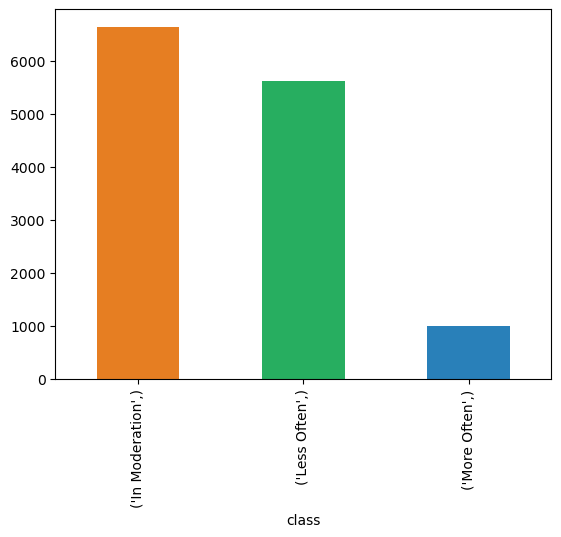

In [8]:
# # Get the row entries with the last col 'class'
food_df.iloc[:, -1:].value_counts(normalize=True)
food_df.iloc[:, -1:].value_counts().plot.bar(color=['#e67e22', '#27ae60', '#2980b9'])
plt.show()

The target variable indicates how often we should include this food item in our diet, and it has three classes `In Moderation`, `Less Often`, `More Often`. It indicates that this is a multi-class classification task and the class distribution is a little bit imbalanced.


## Data processing


Then, let's quickly process the dataset:


First split the features `X` (the input) and labels `y` (the output)


In [9]:
X_raw = food_df.iloc[:, :-1]
y_raw = food_df.iloc[:, -1:]

Then normalize the `X`:


In [10]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()
# Scaling the raw input features
X = scaler.fit_transform(X_raw)

and encode the target variable:


In [11]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

Finally we can split the dataset into training and testing datasets, and we're ready to train a neural network.


In [12]:
rs = 123 # set random state

In [13]:
# First, let's split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Training dataset shape, X_train: (10608, 17), y_train: (10608,)
Testing dataset shape, X_test: (2652, 17), y_test: (2652,)


## Train a Neural Network with SGD (Stochastic Gradient Descent)


As the initial model, we plan to train a basic multilayer perceptron neural network with the following settings:
- Two hidden layers with shapes `(17, 32)` and `(32, 8)`. Note the number `17` represents the dimension of the feature vector X. You may try different hidden layers setting as well.
- Set the solver/optimizer to be SGD
- Disable momentum
- Enable early stopping


In [14]:
base_ann = MLPClassifier(random_state=rs,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0, 
                    early_stopping=True,
                    max_iter=100)

As you may recall, the formula for SGD is using the gradient calculated from instance `i` only:


$$W_t := W_{t-1} - \alpha \nabla_iJ$$


Then we may use the following helper function to quickly train the neural network and report its training and test score.


In [15]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    n_iter = model.n_iter_
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    loss_curve = model.loss_curve_
    return round(fit_time, 2), n_iter, train_score, test_score

In [16]:
fit_time, n_iter, train_score, test_score = fit_and_score(base_ann, X_train, X_test, y_train, y_test)

In [17]:
print(f"Training converged after {n_iter} iterations with train score (accuracy) {round(train_score, 2)} \
and test score (accuracy) {round(test_score, 2)}.")

Training converged after 12 iterations with train score (accuracy) 0.42 and test score (accuracy) 0.42.


As we can see from above cell output, a classification task with accuracy around `40%` is definitly unacceptable. But how is it even possible as we are using a Neural Network to do the task!


Such bad train and test score is normally considered as underfitting which actually happends very often in training neural networks which is normally more complex than shallow models. The reasons could be too simple network architecture, insufficient training data or iterations, trapped in local minima, etc.


For our case, it could be the bad quality or low predictability of our dataset. To verify that, let's try to build a simple logistic regression to see if it can perform the task well.


In [18]:
# Define a logistic regression model with above arguments
lr_model = LogisticRegression(random_state=rs, max_iter = 200)
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print(f"The test score for the logistic regression is {round(lr_score, 2)}")

The test score for the logistic regression is 0.77


Now we can see a logistic linear regression can get around 0.75 accuracy which is much better than the neural network. We can see our dataset is pretty predictable. We must have done something improperly in the neural network training.


One common reason is that the SGD was trapped in one of the local minima. Let's illusrate this idea in the following simple example:


First we define a helper function to draw some cost functions.


In [19]:
def draw_cost(X, Y, Z, title):
    fig = plt.figure()
    fig.set_size_inches(8, 6, forward=True)
    fig.set_dpi(100)
    ax = plt.axes(projection='3d')
    ax.view_init(30, 35)
    ax.contour3D(X, Y, Z, 100, cmap=plt.cm.coolwarm)
    ax.set_title(title)
    plt.show()

Ideally, a cost function only has one global minima and SGD can find it.


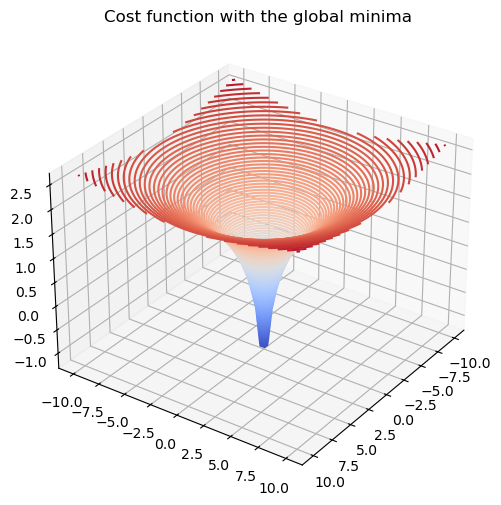

In [20]:
def one_mini_function():
    w1 = np.linspace(-10, 10, 50)
    w2 = np.linspace(-10, 10, 50)
    X, Y = np.meshgrid(w1, w2)
    Z = np.log(np.sqrt(X ** 2 + Y ** 2))
    return X, Y, Z

X, Y, Z = one_mini_function()
draw_cost(X, Y, Z, "Cost function with the global minima")

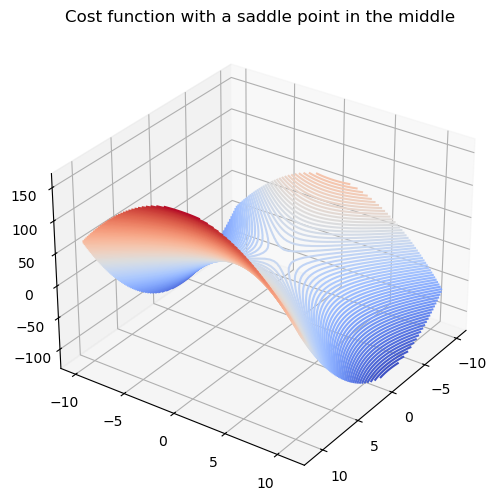

In [21]:
def multi_mini_function():
    w1 = np.linspace(-10, 11, 50)
    w2 = np.linspace(-10, 11, 50)
    X, Y = np.meshgrid(w1, w2)
    Z = X ** 2  - Y ** 2 + 4*X
    return X, Y, Z

X1, Y1, Z1 = multi_mini_function()
draw_cost(X1, Y1, Z1, "Cost function with a saddle point in the middle")

However, if the cost function has multiple minima or even saddle points (where gradients are very small or zeros so the weights won't be updated), the SGD may be stuck at the local minima. For example, the following cost function has a saddle point at `(0, 0)` in the middle which could stop the gradients from further going down, as shown in the following picture:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/saddle.png)


As a result, the total loss won't be reduced and the model would perform badly in the classification task. To tackle this local minima challenge, we could either try to add some noises in SGD or randomly switch the starting point. Furthermore, we may also utilize momentum to make gradient jump out of local minima or saddle points.


## Retrain the Neural Network with momentum


With the regular SGD, the weights are generally moving slowly towards to a optimum (can be a local one like the previous example). Now, with momentum, you're going to smooth out this process. You can do this by taking somewhat of a running average of each of the steps and then smoothing out that variation of each of the individual steps for regular gradient descent.


$$v_t := \eta v_{t-1} + \alpha \nabla J$$


$$W_t := W_{t-1}  - v_t$$


We can see that rather than just simply updating our weights with that gradient, we also look back to prior values $v_{t-1}$ to smooth out these steps. So this is at the step $t$ that we have, which will incorporate some amount of $v_{t-1}$ at step $t-1$. 


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/momentum.png)


As a summary, adding momentum in weights update may bring the following benefits:
1. Smooth the weight updating process by incorporating previous direction
2. Tend to generate larger and consistent steps which may tackle the saddle points problem


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/jumpout.png)


Let's retrain our neural network with momentum. With `MLPClassifier` class, you just need to give a positive momentum value such as 0.9.


In [22]:
momentum_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0.9, 
                    early_stopping=True,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(momentum_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with test score (accuracy) {round(test_score, 2)}")

Training converged after 93 iterations with test score (accuracy) 0.73


Now, as you can see with momentum added in SGD process, our performance gets much better from 0.42 to 0.73. 


### Exercise: Retrain the Neural Network with Nesterov’s momentum


However, sometimes adding momentum may overshoot the minima and make the training process longer. So we may add Nesterov’s momentum to further improve training process.


To use Nesterov’s momentum, you just need to to set argument `nesterovs_momentum=True` in `MLPClassifier` class.`


In [23]:
# Write your code here

nesterovs_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0.95, 
                    nesterovs_momentum=True,
                    early_stopping=True,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(nesterovs_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with score (accuracy) {round(test_score, 2)}")

Training converged after 83 iterations with score (accuracy) 0.74


<details>
    <summary>Click here for a Solution</summary>

```python
nesterovs_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='sgd', momentum=0.95, 
                    nesterovs_momentum=True,
                    early_stopping=True,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(nesterovs_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with score (accuracy) {round(test_score, 2)}")
```

</details>


## Adam Optimizer


For efficient training, sometimes we may want the learning rates to be adaptive, i.e., large learning rate at the beginning and gets decaying over time. Adam combines the concepts of momentum we have seen previously and gradient decaying over time. As such, it could take very smooth steps and avoid overshooting the optima.


Adam is designed to improve the training process, it may either:
- Decrease number of training iterations 
- Improve the model performance by finding a better or global optima


### Exercise: Retrain the Neural Network with Adam optimizer


To use Adam in `MLPClassifier` is also very simple, you just need to change the solver to be 'adam' (which is actually the default setting).


In [24]:
# Write your code here
adam_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='adam',
                    early_stopping=True,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(adam_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with score (accuracy) {round(test_score, 2)}")

Training converged after 73 iterations with score (accuracy) 0.84


<details>
    <summary>Click here for a Solution</summary>

```python
adam_ann = MLPClassifier(random_state=123,  hidden_layer_sizes=(32, 8), 
                    solver='adam',
                    early_stopping=True,
                    max_iter=100)
fit_time, n_iter, train_score, test_score = fit_and_score(adam_ann, X_train, X_test, y_train, y_test)
print(f"Training converged after {n_iter} iterations with score (accuracy) {round(test_score, 2)}")
```

</details>


You should see that Adam has the smallest iterations but best performance. 


If you are interested in how Adam is implemented, you may refer to the following optional section.


## Optional: Implement Adam optimizer from scrach


The momentum or first-moment component:


$$m_t = \beta_1 m_{t-1} + (1-\beta_1) \nabla J$$


$m_t$ also need to be bias-corrected from being a very small number (as it is initialized with zero)


$$\hat{m_t} = \frac{m_t}{1 - \beta_1^t}$$


The shrink or second-moment component:


$$v_t = \beta_2 v_{t-1} + (1-\beta_2) \nabla^2 J$$


$v_t$ also need to be bias-corrected


$$\hat{v_t} = \frac{v_t}{1 - \beta_2^t}$$


$\alpha$ is the initial learning rate or step size.


$\beta_1$ and $\beta_2$ are hyper-parameters normally with default initial values $\beta_1=0.9$, $\beta_2=0.9999$


$\beta_1$ and $\beta_2$ are also decaying with time: 


$$\beta_1 = \beta_1^t$$


$$\beta_2 = \beta_2^t$$


Now, we can put them together into the weight update:


$$w_t = w_{t-1} - \alpha \frac{\hat{m_t}}{\sqrt{\hat{v_t}} + e}$$


Let's try to implement the above Adam formulas with a very simple cost function: 


$J = (w-4)^2 + 2w$ 


Its gradient with respect to `w` is:


$\nabla J = 2(w-4) + 2$ 


In [25]:
# cost function
def cost_function(w):
    return (w - 4) ** 2 + 2*w

## take derivative
def grad_function(w):
    return 2*(w-4) + 2

Let's plot this cost function with the following helper function.


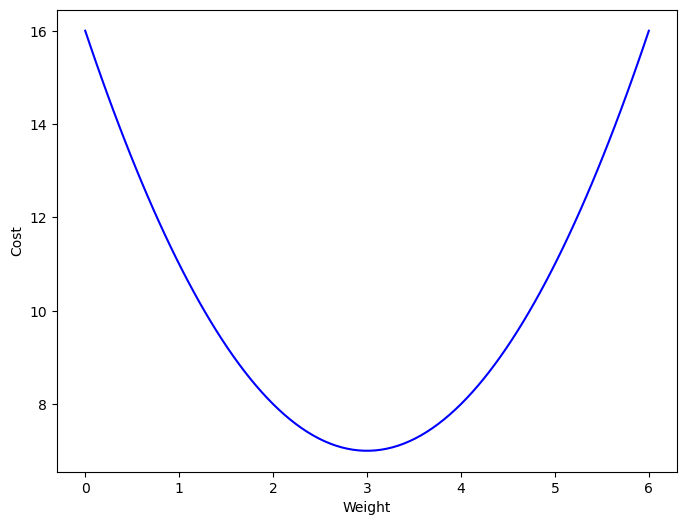

In [26]:
def plot_cost():
    fig, axis = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    fig.set_dpi(100)

    x = np.linspace(0,6,100)
    y = cost_function(x)
    axis.plot(x, y, 'b')
    axis.set_xlabel("Weight")
    axis.set_ylabel("Cost")
    plt.show()

plot_cost()

In [27]:
def is_converged(w0, w1):
    return abs(w0 - w1) <= 1e-6

# Implement Adam
def adam(t, w, dw, m, v, alpha = 0.1, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
    # para
    # First-moment
    m = beta1*m + (1-beta1)*dw
    # Second-moment
    v = beta2*v + (1-beta2)*(dw**2)
    # Bias correction
    m_unbiased = m/(1-beta1**t)
    v_unbiased = v/(1-beta2**t)
    # Update weights
    w = w - alpha*(m_unbiased/(np.sqrt(v_unbiased) + epsilon))
    return w, m, v

Next, we could use the gradients and Adam to optimize the cost function:


In [28]:
w,m,v,t = 0,0,0,1
converged = False
w_his = []
loss_his = []
while not converged:
    dw = grad_function(w)
    w_prev = w
    w, m, v = adam(t, w, dw, m, v)
    loss_his.append(cost_function(w))
    w_his.append(w)
    if is_converged(w, w_prev):
        break
    else:
        t+=1

In [29]:
def plot_cost_w_grad(w_his, loss_his):
    fig, axis = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    fig.set_dpi(100)
    x = np.linspace(-2,6,100)
    y = cost_function(x)
    axis.scatter(w_his, loss_his, marker='<', color='r', s=18)
    axis.plot(x, y, 'grey')
    axis.text(0, 16, 'Iteration 0', fontsize=8)
    axis.text(3, 8, f'Iteration {len(loss_his)}', fontsize=8)
    axis.set_xlabel("Weight")
    axis.set_ylabel("Cost")
    plt.show()

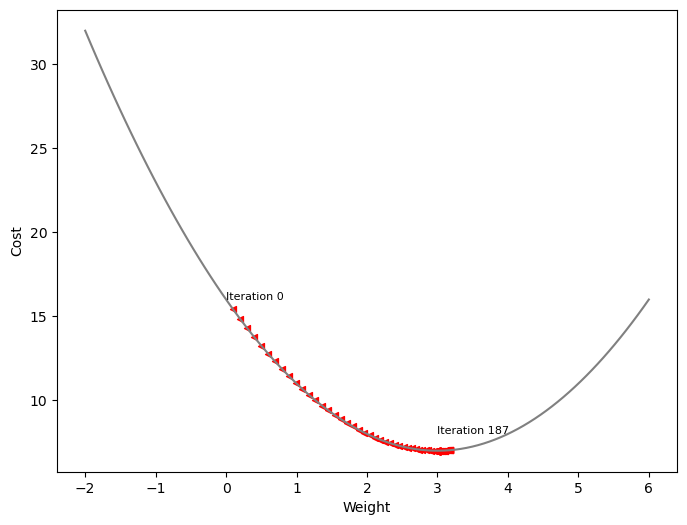

In [30]:
plot_cost_w_grad(w_his, loss_his)

As you can see from above plot, the weights updated by Adam are gradually reaches to the global minima.


## Exercise: Comparing Optimization Methods on Fashion MNIST


In this exercise, we will build a simple neural network model to classify Fashion MNIST images.

We will use the 2 optimizers we discussed above, with 3 different settings. These include: SGD with disabled momentum, SGD with momentum and Adam. In all three settings we will use the same base model architecture to allow for direct comparison.


In [31]:
NAMES = ['SGD', 'SGD_momentum', 'Adam']

Let us start by loading and splitting our data into testing and training sets.


In [32]:
# Write your code here

# TODO: load and split data

(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()


<details>
    <summary>Click here for Solution</summary>
   
```python
(xtrain, ytrain), (xtest, ytest) = fashion_mnist.load_data()
```
</details>


Now we will reshape our `xtrain` and `xtest` such that they're in the shape `(len(xtrain), -1)` and `(len(xtest), -1)`, respectively. We will also convert our target labels to categorical values using `to_categorical()`


In [33]:
# Write your code here

# TODO: reshape xtrain and xtest

xtrain = np.reshape(xtrain, (len(xtrain), -1))
xtest = np.reshape(xtest, (len(xtest), -1))
# TODO: convert ytrain, ytest to categorical

ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

<details>
    <summary>Click here for Solution</summary>
   
```python
xtrain = np.reshape(xtrain, (len(xtrain), -1))
xtest = np.reshape(xtest, (len(xtest), -1))

ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)
```
</details>



In the next step, we will perform basic normalization. We will also carve out a small validation set out of our original training dataset.  


In [34]:
# normalization
xtrain = np.apply_along_axis(lambda x: x/255, 1, xtrain)
xtest = np.apply_along_axis(lambda x: x/255, 1, xtest)

# validation set
index = 50000
xval, yval = xtrain[index:], ytrain[index:]
xtrain, ytrain = xtrain[:index], ytrain[:index]
xtrain.shape, xval.shape, xtest.shape

((50000, 784), (10000, 784), (10000, 784))

Let us define a simple sequential neural network model. In the cell below set the input shape of the first Dense layer to `xtrain.shape[1:]`. Finally, build the model with the same input shape.


In [35]:
# Write your code here
model = Sequential(
[
    Dense(128, 
          input_shape=xtrain.shape[1:],
          activation='relu', 
          name='dense_1'),
    Dense(64, 
          activation='relu', 
          name='dense_2'),
    Dropout(0.2),
    Dense(10, 
          activation='softmax', 
          name='dense_3')
], name='Sequential')

model.build(input_shape=xtrain.shape[1:])
model.summary()

Model: "Sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               100480    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


<details>
    <summary>Click here for Solution</summary>
   
```python
model = Sequential(
[
    Dense(128, 
          input_shape=xtrain.shape[1:],
          activation='relu', 
          name='dense_1'),
    Dense(64, 
          activation='relu', 
          name='dense_2'),
    Dropout(0.2),
    Dense(10, 
          activation='softmax', 
          name='dense_3')
], name='Sequential')

model.build(input_shape=xtrain.shape[1:])
model.summary()
```
</details>



We will be using a popular Python library called `tqdm` to keep track of the training of our 3 models. Each model will be trained for 10 epochs, and for each iteration we will save the results in separate dictionary objects.


In [36]:
# params
epochs = 10
batch_size = 64
shuffle = True

# dicts for storing results
loss      = {opt:[] for opt in NAMES}
val_loss  = {opt:[] for opt in NAMES}
acc       = {opt:[] for opt in NAMES}
val_acc   = {opt:[] for opt in NAMES}
test_acc  = {}
test_loss = {}

In the cell below, define three different types of optimizers with the following settings: **(Note that this may take a while to run (10+ minutes))**
    
* SGD: lr = 0.001
* SGD: lr = 0.001, momentum = 0.9
* Adam: lr = 0.001, beta_1 = 0.9, beta_2 = 0.999 


In [37]:
# Write your code here
weights = model.get_weights().copy()

with tqdm(desc='Training', total=len(NAMES*epochs)) as pbar:
    for name in NAMES:
        optimizer=''
        
        # prepare model
        model.set_weights(weights)
        if name == 'SGD':
            optimizer= SGD(lr=0.001)
        elif name=='SGD_momentum':
            optimizer=SGD(lr=0.001, momentum=0.9)
        elif name=='Adam':
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
        print('Optimizer: ', name)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
        
        # train model
        for epoch in range(epochs):
            his = model.fit(xtrain, ytrain,
                            epochs=1,
                            batch_size=batch_size,
                            validation_data=(xval, yval),
                            shuffle=shuffle,
                            verbose=0)
            
            # update dictionaries
            loss[name].append(his.history['loss'][0])
            val_loss[name].append(his.history['val_loss'][0])
            acc[name].append(his.history['acc'][0])
            val_acc[name].append(his.history['val_acc'][0])   
            pbar.update(1)
            
        # inference
        t_loss, t_acc = model.evaluate(xtest, ytest, verbose=0)
        test_loss[name] = t_loss
        test_acc[name] = t_acc


Training:   0%|          | 0/30 [00:00<?, ?it/s]

Optimizer:  SGD
Optimizer:  SGD_momentum
Optimizer:  Adam


<details>
    <summary>Click here for Solution</summary>
   
```python
weights = model.get_weights().copy()

with tqdm(desc='Training', total=len(NAMES*epochs)) as pbar:
    for name in NAMES:
        optimizer=''
        
        # prepare model
        model.set_weights(weights)
        if name == 'SGD':
            optimizer= SGD(lr=0.001)
        elif name=='SGD_momentum':
            optimizer=SGD(lr=0.001, momentum=0.9)
        elif name=='Adam':
            optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
        print('Optimizer: ', name)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
        
        # train model
        for epoch in range(epochs):
            his = model.fit(xtrain, ytrain,
                            epochs=1,
                            batch_size=batch_size,
                            validation_data=(xval, yval),
                            shuffle=shuffle,
                            verbose=0)
            
            # update dictionaries
            loss[name].append(his.history['loss'][0])
            val_loss[name].append(his.history['val_loss'][0])
            acc[name].append(his.history['acc'][0])
            val_acc[name].append(his.history['val_acc'][0])   
            pbar.update(1)
            
        # inference
        t_loss, t_acc = model.evaluate(xtest, ytest, verbose=0)
        test_loss[name] = t_loss
        test_acc[name] = t_acc


```
</details>



Finally, let us visualize the results we saved during the training procedure.


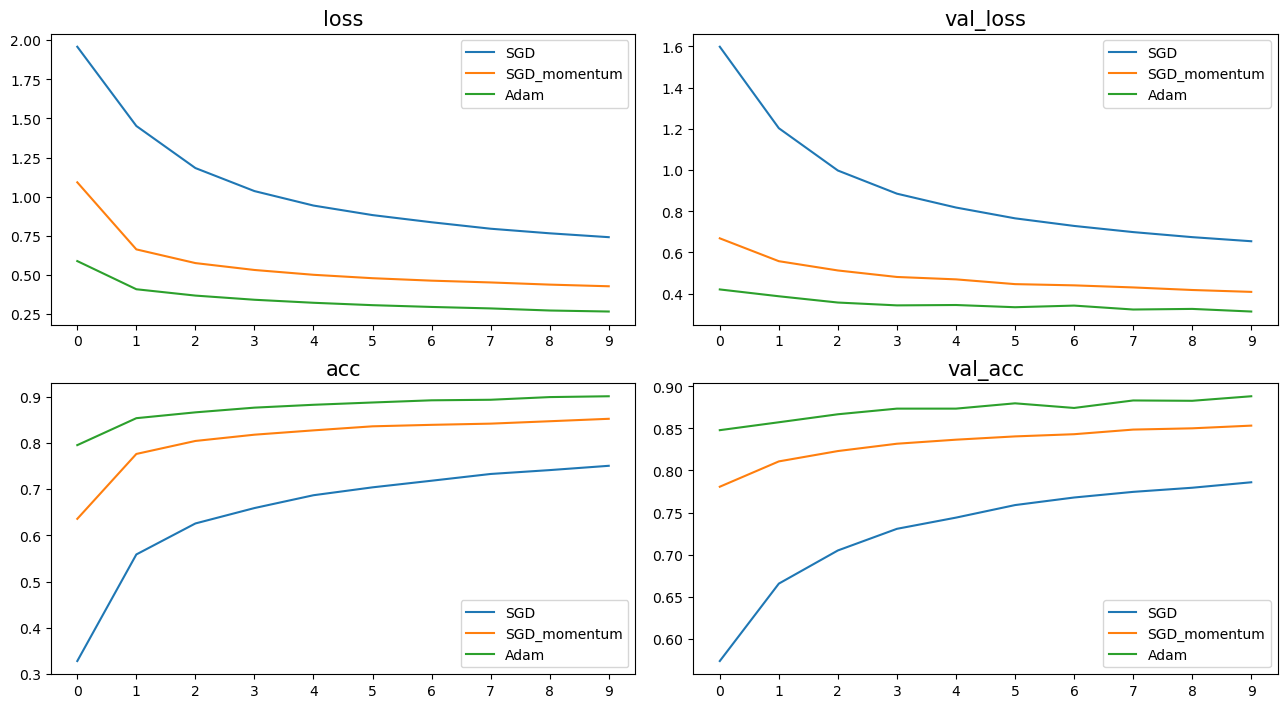

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(13, 7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)


for index, result, title in zip([[0, 0], [0, 1], [1, 0], [1, 1]], 
                                [loss, val_loss, acc, val_acc], 
                                ['loss', 'val_loss', 'acc', 'val_acc']):
    i, j = index
    for name, values in result.items():
        axs[i, j].plot(values, label=name)
        axs[i, j].set_title(title, size=15)
        axs[i, j].set_xticks([e for e in range(epochs)])
        axs[i, j].legend(loc="best", prop={'size': 10})

plt.show()

As seen above, SGD with momentum outperforms SGD without momentum. In this case, Adam performs the best. In fact, it works well in most cases so it often set to be the default optimizer for many neural network models.


Let us look at a few images from our test dataset and see how our model classifies them.


313/313 [==============================] - 2s 7ms/step


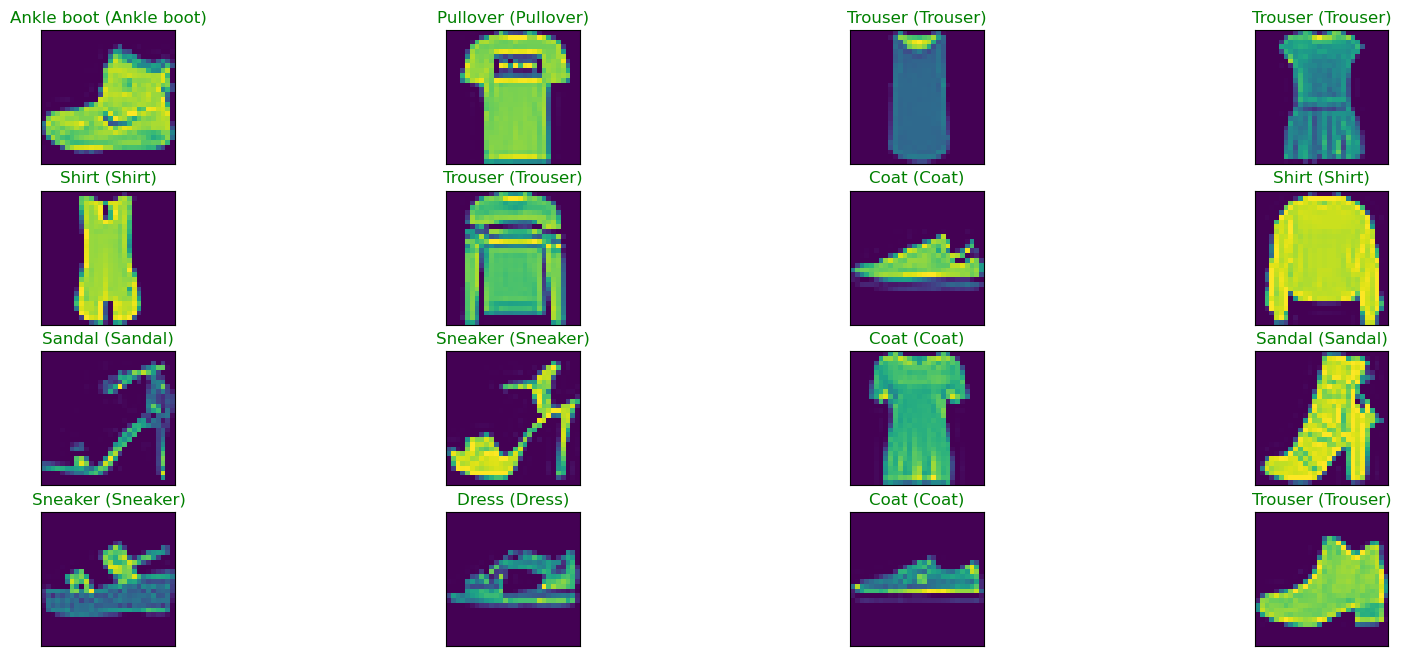

In [39]:
w, h = 28, 28
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

y_hat = model.predict(xtest)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(range(16)):
    
    ax = figure.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(xtrain.reshape(xtrain.shape[0], w, h, 1)[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(ytest[index])
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index],
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

plt.show()
    

### Summary


Congratulations, you have completed the optimiers lab. Now you have learned and practiced with different optimizers.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01)


### Other contributors 
[Kopal Garg](https://www.linkedin.com/in/gargkopal/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) 


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2022-06-10|1.0|Yan|Created the initial version|
|2022-06-21|1.0|Roxanne Li|Review and edit content|
|2022-08-10|1.0|Kopal Garg|Add exercise|
|2022-11-11|1.0|Kopal Garg|Review and edit content|


Copyright © 2021 IBM Corporation. All rights reserved.
